# Data Preparation for Carouge Models

The aim of this file is to ingest data, provided by data fusions (JSON files with feature vectors) and create actual datasets that will be later used for building Deep Learning models. The models include Suisse meteo data.

## Feature Vectors

Feature vectors are simply those generated by Data Fusion.

## Target Vectors

Target vectors are 160-hour profiles (1 measurement every 2 hours), generated from the first value (mean of 1h) of target vectors. We could allow NaNs, which we can interpolate.

## Final results

Final results are stored in `features_carouge_sm_?.json` files. These files should be loaded into `naiades-jsi/Carouge` and used for training the models. Additionally, models can be tested in `02 Modeling.ipynb`.

In [4]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json

In [70]:
# function that determines whether a profile is a descending one
def descends(series):
    descends = True
    for i in range(5, len(series)):
        # if later value is larger than previous, then the series
        # ascennds in between
        if(series[i] > series[i-5] + 1):
            descends = False
    return(descends)

# find if profile has zeros
def no_zeros(series):
    z = 0
    for i in range (len(series)):
        if (series[i] < 0.5):
            z = z + 1
    if z >= 1:
        return False
    return True

Flowerbed1: 1770 feature vectors
Flowerbed2: 1784 feature vectors
Flowerbed3: 1866 feature vectors
Flowerbed4: 834 feature vectors
Flowerbed5: 1193 feature vectors
Flowerbed6: 660 feature vectors
Flowerbed7: 645 feature vectors
Flowerbed8: 1915 feature vectors


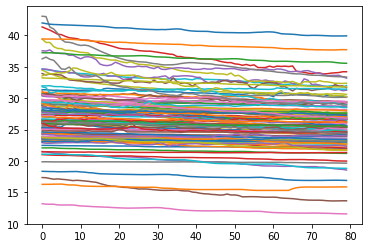

In [77]:
# read data fusion's feature vectors and moisture device sensors, to construct x_train and y_train
folder = '../data/features/'
files = [
    'features_carouge_sm_1.json',
    'features_carouge_sm_2.json',
    'features_carouge_sm_3.json',
    'features_carouge_sm_4.json',
    'features_carouge_sm_5.json',
    'features_carouge_sm_6.json',
    'features_carouge_sm_7.json',
    'features_carouge_sm_8.json'
]

# iterate through all the feature sets
for N in [0, 1, 2, 3, 4, 5, 6, 7]:
    
    # read the content of the files
    with open(folder + files[N], 'r') as f:
        lines = f.readlines()

    # set timestamp and feature vector to an empty set
    f_t = []
    f_ftr = []
    # transverse through the lines, that represent a single feature vector
    # build an array of timestamps and features
    for idx, l in enumerate(lines[1:]):
        f_t.append(json.loads(l)['timestamp'])
        f_ftr.append(json.loads(l)['ftr_vector'])
        
    # empty holders
    profiles = []
    f_time = []
    f_ftrv = []

    # iterate through all the features
    horizons = 80
    for i in range(len(f_t) - 2 * horizons):
        ts = f_t[i]
        # iterate through all the horizons and build profile
        profile = []
        for h in range(horizon):
            n_ts = f_t[i + 2 * h]
            h_new = (n_ts - ts) / 3600000
            if np.round(2 * h) != 2 * h:
                print(ts, h_new, "no!")
                pass
            else:
                profile.append(f_ftr[i + h][0])
        # if profile is nice for the model,
        # add it to the group
        if (descends(profile)) and (no_zeros(profile)):
            f_time.append(ts)
            f_ftrv.append(f_ftr[i])
            profiles.append(profile)

    # saving to the file
    print(f'Flowerbed{N+1}: {len(profiles)} feature vectors')
    i = 0
    for prof in profiles:
        i = i + 1
        if i % 100 == 0:
            plt.plot(prof)

    try:
        d = np.array([0, 0], dtype = object)        
        # manual normalizations - features (0)
        d[0] = np.array(np.array(f_ftrv)[:, :7])/30
        # manual normalization - targets (1)
        d[1] = np.array(profiles)/30        
    except Exception as e:
        print("Exception: %s", str(e))
        pass


    # saving the data into a npy file
    # this data will be used for modeling
    np.save(f'flowerbed{N+1}_160h_new.npy',d, allow_pickle = True)


## Average Profile

From the picture above not much can be deduced, therefore we calulate an average profile.

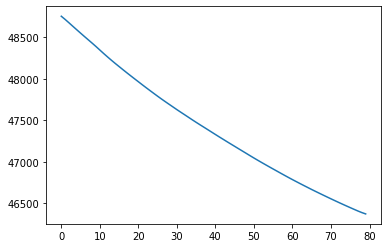

In [78]:
# average profile calculation
profile = np.array(profiles[0])

for p in profiles:
    profile = profile + p
    
plt.plot(profile)